In [9]:
import random
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange

from tqdm import tqdm
from sklearn.metrics import f1_score
from transformers import BertConfig, BertModel, BertTokenizer, BertForPreTraining

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn import preprocessing

## 전체 코드 process
    1. 데이터 전처리
        - 결측치 확인
        - outlier 제거
    2. 데이터 처리 및 representation 구성
        - Antigen: 4가지 protein feature (isoelectric_point, aromaticity, gravy, instability_index)
        - epitope: transformer로 부터 학습된 [CLS] token의 embedding
    3. 모델링
        - 적절한 사이즈의 transforemr encoder를 쌓아 모델 구성
        - Transformer로 부터 학습된 epitope의 embedding과 antigen의 4가지 protein feature를 합친 후 dense layer를 거쳐 classification
        - Data의 imbalance가 크기 때문에 Focal loss를 loss function으로 사용
        - 5 fold cross validation의 결과를 바탕으로 hard voting ensemble을 진행

# 데이터 전처리

In [3]:
# 데이터 불러오기
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,epitope_seq,antigen_seq,antigen_code,start_position,end_position,number_of_tested,number_of_responses,assay_method_technique,assay_group,disease_type,disease_state,reference_date,reference_journal,reference_title,reference_IRI,qualitative_label,label
0,200001,KGILSN,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,P02622.1,3.0,8.0,NaN,NaN,antigen inhibition,qualitative binding,Occurrence of allergy,allergic disease,1976,Int Arch Allergy Appl Immunol,The allergenic structure of allergen M from co...,http://www.iedb.org/reference/1005599,Positive,1
1,200002,SNADIK,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,P02622.1,7.0,12.0,NaN,NaN,antigen inhibition,qualitative binding,Occurrence of allergy,allergic disease,1976,Int Arch Allergy Appl Immunol,The allergenic structure of allergen M from co...,http://www.iedb.org/reference/1005599,Positive,1
2,200003,EGSFDEDGFYAKVGLDAFSADELK,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,P02622.1,21.0,44.0,NaN,NaN,antigen inhibition,qualitative binding,Occurrence of allergy,allergic disease,1976,Int Arch Allergy Appl Immunol,The allergenic structure of allergen M from co...,http://www.iedb.org/reference/1005599,Positive,1
3,200004,SFDEDGFY,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,P02622.1,23.0,30.0,NaN,NaN,antigen inhibition,qualitative binding,Occurrence of allergy,allergic disease,1976,Int Arch Allergy Appl Immunol,The allergenic structure of allergen M from co...,http://www.iedb.org/reference/1005599,Positive,1
4,200005,DEDGFY,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,P02622.1,25.0,30.0,NaN,NaN,antigen inhibition,qualitative binding,Occurrence of allergy,allergic disease,1976,Int Arch Allergy Appl Immunol,The allergenic structure of allergen M from co...,http://www.iedb.org/reference/1005599,Positive,1


In [4]:
# antigen과 epitope 길이 가져오기
train_df['antigen_length'] = train_df.antigen_seq.map(lambda a:len(a))
train_df['epitope_length'] = train_df.epitope_seq.map(lambda a:len(a))

In [5]:
# 데이터 전체에 결측치 확인하기
# epitope_seq, antigen_seq, antigen_length, epitope_length만 사용할 예정이기 때문에 다른 column에 결측치가 있어도 상관 없다.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190811 entries, 0 to 190810
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      190811 non-null  int64  
 1   epitope_seq             190811 non-null  object 
 2   antigen_seq             190811 non-null  object 
 3   antigen_code            190811 non-null  object 
 4   start_position          190811 non-null  float64
 5   end_position            190811 non-null  float64
 6   number_of_tested        39198 non-null   float64
 7   number_of_responses     38353 non-null   float64
 8   assay_method_technique  190811 non-null  object 
 9   assay_group             190811 non-null  object 
 10  disease_type            190811 non-null  object 
 11  disease_state           180793 non-null  object 
 12  reference_date          190811 non-null  int64  
 13  reference_journal       190811 non-null  object 
 14  reference_title     

In [6]:
# 사용할 column만 남기기
col = ['epitope_seq', 'antigen_seq', 'antigen_length', 'epitope_length']
train_df = train_df[col]
train_df.head()

,epitope_seq,antigen_seq,antigen_length,epitope_length
0,KGILSN,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,113,6
1,SNADIK,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,113,6
2,EGSFDEDGFYAKVGLDAFSADELK,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,113,24
3,SFDEDGFY,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,113,8
4,DEDGFY,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,113,6


In [7]:
# Antigen_length 분포 확인하기
train_df.describe()

,antigen_length,epitope_length
count,190811.000000,190811.000000
mean,471.218006,14.462762
std,423.717996,2.478726
min,13.000000,2.000000
25%,258.000000,15.000000
50%,379.000000,15.000000
75%,507.000000,15.000000
max,4967.000000,250.000000


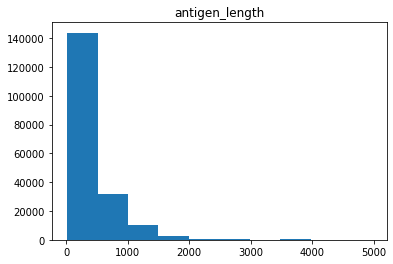

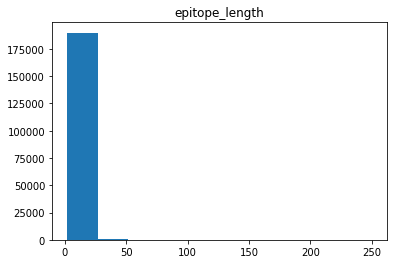

In [10]:
plt.hist(train_df['antigen_length'])
plt.title('antigen_length')
plt.show()

plt.hist(train_df['epitope_length'])
plt.title('epitope_length')
plt.show()

In [11]:
# 현재 문제에서 epitope부분이 중요하고 대부분이 50 이하의 길이를 가진다. 따라서 50이상의 길이를 가진 eptiope을 확인
train_df[train_df['epitope_length'] > 50]
# Max length는 250 이지만 나머지 모든 epitope는 60이하의 길이를 가지는 것을 확인(7511)

,epitope_seq,antigen_seq,antigen_length,epitope_length
781,LAQTHSAIAVIIGIKDLDAFRHYDGRTIIQRDNGYQPNYHAVNIVG...,RPSSIKTFEEYKKAFNKSYATFEDEEAARKNFLESVKYVQSNGGAI...,302,57
782,QSCRRPNAQRFGISNYCQIYPPNANKIREALAQTHSAIAVIIGIKD...,RPSSIKTFEEYKKAFNKSYATFEDEEAARKNFLESVKYVQSNGGAI...,302,54
783,QELVDCASQHGCHGDTIPRGIEYIQHNGVVQESYYRYVAREQSCRR...,MKIVLAIASLLALSAVYARPSSIKTFEEYKKAFNKSYATFEDEEAA...,320,52
795,TNACSINGNAPAEIDLRQMRTVTPIRMQGGCGSCWAFSGVAATESA...,MSAEAFEHLKTQFDLNAETNACSINGNAPAEIDLRQMRTVTPIRMQ...,96,56
7387,WAQSTDFPQFKPEEITAIMNDFNEPGSLAPTGLYLGGTKYMVIQGE...,MSWQAYVDDHLLCDIEGNHLTHAAIIGQDGSVWAQSTDFPQFKPEE...,131,56
7511,ETTARIIFNGKDLNLVERRIAAVNPSDPLETTKPDMTLKEALKIAF...,MKKRKVLIPLMALSTILVSSTGNLEVIQAEVKQENRLLNESESSSQ...,764,250
11502,TAGEGIVIYGVDTGIDIGHADFGGRAEWGTNTADNDDTDGNGHGTH...,MGFLKLLSTSLATLAVVNAGKLLTANDGDEVVPSSYIVVMNDGVST...,398,52
11504,FGGRAEWGTNTADNDDTDGNGHGTHTASTAAGSKFGVAKKASVVAV...,MGFLKLLSTSLATLAVVNAGKLLTANDGDEVVPSSYIVVMNDGVST...,398,51
11598,EGLRMMMRMMQQKEMQPRGEQMRRMMRLAENIPSRCNLSPMRCPMG...,MAKISVAAAALLVLMALGHATAFRATVTTTVVEEENQEECREQMQR...,146,52
13228,CVCRSCRTMSLQKTVEKLFDELDKDKSGKISCAELKSALQSCSAEP...,CVCRSCRTMSLQKTVEKLFDELDKDKSGKISCAELKSALQSCSAEP...,76,51


In [13]:
# 250의 길이를 가진 epitope_seq는 제거 (outlier)
train_df = train_df.drop([7511])
train_df = train_df.reset_index(drop=True)

# Hyperparameter Setting

In [3]:
CFG = {
    'NUM_WORKERS':4,
    'EPITOPE_MAX_LEN':62,
    'EPOCHS':20,
    'LEARNING_RATE':5e-5,
    'BATCH_SIZE':1024,
    'THRESHOLD':0.5,   # 기본적으로 0.5로 사용하지만 data impalance가 심할 경우 더 큰 값을 사용하기도 한다.
    'SEED':41
}

device = torch.device('cuda:4') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

# Data processing

In [14]:
# huggingface protein tokenizer 불러오기
tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert_bfd', do_lower_case=False)

def seqtoinput(seq):
    for j in range(len(seq)-1):
        seq = seq[:j+j+1]+ ' ' + seq[j+j+1:]
    return seq 

# Antigen은 너무 길이가 길기 때문에 LM로 embedding을 얻는 것보다 protein feature를 얻는 것이 더 좋을 것이라고 생각해 아래의 4가지 feature를 사용
def get_protein_feature(seq):
    protein_feature = []
    protein_feature.append(ProteinAnalysis(seq).isoelectric_point())
    protein_feature.append(ProteinAnalysis(seq).aromaticity())
    protein_feature.append(ProteinAnalysis(seq).gravy())
    protein_feature.append(ProteinAnalysis(seq).instability_index())
    return protein_feature

def get_preprocessing(data_type, new_df, tokenizer):
    epitope_ids_list = []
    epitope_mask_list = []
    
    protein_features = []
#     epitope_features = []
        
    for epitope, antigen, s_p, e_p in tqdm(zip(new_df['epitope_seq'], new_df['antigen_seq'], new_df['start_position'], new_df['end_position'])):             
        protein_features.append(get_protein_feature(antigen))
#         epitope_features.append(get_peptide_feature(epitope))
        
        epitope = seqtoinput(epitope)
        
        
        epitope_input = tokenizer(epitope, add_special_tokens=True, pad_to_max_length=True, max_length = 62)
        epitope_ids = epitope_input['input_ids']
        epitope_mask = epitope_input['attention_mask']
        
        
        epitope_ids_list.append(epitope_ids)
        epitope_mask_list.append(epitope_mask)

    
    label_list = None
    if data_type != 'test':
        label_list = []
        for label in new_df['label']:
            label_list.append(label)
    print(f'{data_type} dataframe preprocessing was done.')
    
    
    return epitope_ids_list, epitope_mask_list, protein_features, label_list

In [15]:
class CustomDataset(Dataset):
    def __init__(self, epitope_ids_list, epitope_mask_list, protein_features, label_list):
        self.epitope_ids_list = epitope_ids_list
        self.epitope_mask_list = epitope_mask_list
        self.protein_features = protein_features

        self.label_list = label_list
        
    def __getitem__(self, index):
        self.epitope_ids = self.epitope_ids_list[index]
        self.epitope_mask = self.epitope_mask_list[index]
        
        self.protein_feature = self.protein_features[index]        
        
        if self.label_list is not None:
            self.label = self.label_list[index]
            return torch.tensor(self.epitope_ids), torch.tensor(self.epitope_mask), torch.tensor(self.protein_feature, dtype=torch.float32), self.label
        else:
            return torch.tensor(self.epitope_ids), torch.tensor(self.epitope_mask), torch.tensor(self.protein_feature, dtype=torch.float32)
        
    def __len__(self):
        return len(self.epitope_ids_list)

In [16]:
# huggingface를 활용해 transformer encoder layer가 12개 쌓인 모델 구성하기
config = BertConfig(
    vocab_size=30,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.0,
    max_position_embeddings=62,
    type_vocab_size=2, 
)

pre = BertForPreTraining(config=config)
pre.save_pretrained('model/bert')

# Model

In [11]:
class TransformerModel(nn.Module):
    def __init__(self,
                 protein_hidden_dim=768,
                 pretrained_model='model/bert'
                ):
        super(TransformerModel, self).__init__()              
        # Transformer                
        self.transformer = BertModel.from_pretrained(pretrained_model)
                
        in_channels = protein_hidden_dim + 4
            
        self.classifier = nn.Sequential(
            nn.LeakyReLU(True),
            nn.BatchNorm1d(in_channels),
            nn.Linear(in_channels, protein_hidden_dim//4),
            nn.LeakyReLU(True),
            nn.BatchNorm1d(protein_hidden_dim//4),
            nn.Linear(protein_hidden_dim//4, 1)
        )
        
    def forward(self, epitope_ids_list, epitope_mask_list, protein_features):
        # Get Embedding Vector
        epitope_x = self.transformer(input_ids=epitope_ids_list, attention_mask=epitope_mask_list)[0]
        
        # transformer [CLS]
        epitope_hidden = epitope_x[:, 0, :]
                        
        # Feature Concat -> Binary Classifier
        x = torch.cat([epitope_hidden, protein_features], axis=-1)
        x = self.classifier(x).view(-1)
        return x

# Loss

In [12]:
class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).to(device)
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [13]:
def train(model, optimizer, train_loader, val_loader, scheduler, device, split):
    model.to(device)
    criterion = WeightedFocalLoss().to(device) 
    best_val_f1 = 0
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for epitope_ids_list, epitope_mask_list, protein_features, label in tqdm(iter(train_loader)):
            epitope_ids_list = epitope_ids_list.to(device)
            epitope_mask_list = epitope_mask_list.to(device)

            protein_features = protein_features.to(device)

            label = label.float().to(device)
            
            optimizer.zero_grad()
            
            output = model(epitope_ids_list, epitope_mask_list, protein_features)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
            if scheduler is not None:
                scheduler.step()
                    
        val_loss, val_f1, val_acc, val_f1_T, val_f1_F = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val F1 : [{val_f1:.5f}] Val acc : [{val_acc:.5f}] Val F1_T : [{val_f1_T:.5f}] Val F1_F : [{val_f1_F:.5f}] ')
        
        if best_val_f1 < val_f1:
            best_val_f1 = val_f1
#             torch.save(model.module.state_dict(), 'epitope_best_model_{split}.pth', _use_new_zipfile_serialization=False)
            # multi GPU를 사용했기 때문에 model.module로 모델 저장
            torch.save(model.module.state_dict(), f'epitope_best_model_{split}.pth', _use_new_zipfile_serialization=False)
            print('Model Saved.')
    return best_val_f1

In [14]:
from sklearn.metrics import accuracy_score

def validation(model, val_loader, criterion, device):
    model.eval()
    pred_proba_label = []
    true_label = []
    val_loss = []
    with torch.no_grad():
        for epitope_ids_list, epitope_mask_list, protein_features, label in tqdm(iter(val_loader)):
            epitope_ids_list = epitope_ids_list.to(device)
            epitope_mask_list = epitope_mask_list.to(device)

            protein_features = protein_features.to(device)
            
            label = label.float().to(device)
            
            model_pred = model(epitope_ids_list, epitope_mask_list, protein_features)
            loss = criterion(model_pred, label)
            model_pred = torch.sigmoid(model_pred).to('cpu')
            
            pred_proba_label += model_pred.tolist()
            true_label += label.to('cpu').tolist()
            
            val_loss.append(loss.item())
    
    pred_label = np.where(np.array(pred_proba_label)>CFG['THRESHOLD'], 1, 0)
    val_f1 = f1_score(true_label, pred_label, average='macro')
    f1_T = f1_score(true_label, pred_label)
    f1_F = f1_score(true_label, pred_label, pos_label=0)
    acc = accuracy_score(true_label, pred_label)
    return np.mean(val_loss), val_f1, acc, f1_T, f1_F

# test data 불러오기

In [15]:
test_df = pd.read_csv('data/test.csv')
test_epitope_ids_list, test_epitope_mask_list, test_protein_features, test_label_list= get_preprocessing('test', test_df, tokenizer)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
120944it [19:35, 102.85it/s]

test dataframe preprocessing was done.


In [16]:
def inference(model, test_loader, device):
    model.eval()
    pred_proba_label = []
    with torch.no_grad():
        for epitope_ids_list, epitope_mask_list, protein_features in tqdm(iter(test_loader)):
            epitope_ids_list = epitope_ids_list.to(device)
            epitope_mask_list = epitope_mask_list.to(device)

            protein_features = protein_features.to(device)
            
            model_pred = model(epitope_ids_list, epitope_mask_list, protein_features)
            model_pred = torch.sigmoid(model_pred).to('cpu')
            
            pred_proba_label += model_pred.tolist()
    
    pred_label = np.where(np.array(pred_proba_label)>CFG['THRESHOLD'], 1, 0)
    return pred_label

# 5 fold cv + prediction
시간 문제로 효율적인 코드를 작성하지는 못했습니다.

In [18]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=48,shuffle=True)
split = 1
results = []

for trn_idx, val_idx in kf.split(train_df):
    trn, val = train_df.iloc[trn_idx], train_df.iloc[val_idx]
    
    train_epitope_ids_list, train_epitope_mask_list, train_protein_features, train_label_list = get_preprocessing('train', trn, tokenizer)
    val_epitope_ids_list, val_epitope_mask_list, val_protein_features, val_label_list = get_preprocessing('val', val, tokenizer)

    standard_scaler = preprocessing.StandardScaler()
    standard_scaler = standard_scaler.fit(train_protein_features)

    train_protein_features = standard_scaler.transform(train_protein_features)
    val_protein_features = standard_scaler.transform(val_protein_features)

    train_dataset = CustomDataset(train_epitope_ids_list, train_epitope_mask_list, train_protein_features, train_label_list)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

    val_dataset = CustomDataset(val_epitope_ids_list, val_epitope_mask_list, val_protein_features, val_label_list)
    val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])
    
    model = TransformerModel()
    model = nn.DataParallel(model, device_ids=[4, 5, 6])
    model.eval()

    optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000*CFG['EPOCHS'], eta_min=0)

    best_score = train(model, optimizer, train_loader, val_loader, scheduler, device, split)
    print(f'Best Validation F1 Score : [{best_score:.5f}]')
    
    test_pf = standard_scaler.transform(test_protein_features)
    
    test_dataset = CustomDataset(test_epitope_ids_list, test_epitope_mask_list, test_pf, None)
    test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])
    
    model = TransformerModel()
    best_checkpoint = torch.load(f'epitope_best_model_{split}.pth', map_location=device)
    model.load_state_dict(best_checkpoint)
    model.eval()
    model.to(device)
    
    preds = inference(model, test_loader, device)
    results.append(preds)
    
    submit = pd.read_csv('data/sample_submission.csv')
    submit['label'] = preds

    submit.to_csv(f'submission/epitope_submission_{split}.csv', index=False)
    print('Done.')
    
    split += 1


0it [00:00, ?it/s]/usr/local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
152648it [03:57, 642.93it/s] 


train dataframe preprocessing was done.


38162it [00:58, 647.33it/s] 


val dataframe preprocessing was done.


Some weights of the model checkpoint at model/bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Epoch : [1] Train Loss : [0.04681] Val Loss : [0.03734] Val F1 : [0.69575] Val acc : [0.89183] Val F1_T : [0.45150] Val F1_F : [0.94000] 
Model Saved.


100%|██████████| 38/38 [00:42<00:00,  1.12s/it]

Epoch : [2] Train Loss : [0.04162] Val Loss : [0.03848] Val F1 : [0.66876] Val acc : [0.85446] Val F1_T : [0.42073] Val F1_F : [0.91678] 



100%|██████████| 38/38 [00:43<00:00,  1.15s/it]


Epoch : [3] Train Loss : [0.03897] Val Loss : [0.03517] Val F1 : [0.69870] Val acc : [0.88774] Val F1_T : [0.46005] Val F1_F : [0.93736] 
Model Saved.


100%|██████████| 38/38 [00:42<00:00,  1.13s/it]


Epoch : [4] Train Loss : [0.03677] Val Loss : [0.03468] Val F1 : [0.71059] Val acc : [0.90564] Val F1_T : [0.47300] Val F1_F : [0.94818] 
Model Saved.


100%|██████████| 38/38 [00:41<00:00,  1.08s/it]

Epoch : [5] Train Loss : [0.03487] Val Loss : [0.03421] Val F1 : [0.70635] Val acc : [0.89490] Val F1_T : [0.47105] Val F1_F : [0.94165] 



100%|██████████| 38/38 [00:44<00:00,  1.17s/it]


Epoch : [6] Train Loss : [0.03313] Val Loss : [0.03249] Val F1 : [0.71466] Val acc : [0.89830] Val F1_T : [0.48576] Val F1_F : [0.94357] 
Model Saved.


100%|██████████| 38/38 [00:44<00:00,  1.16s/it]


Epoch : [7] Train Loss : [0.03155] Val Loss : [0.03167] Val F1 : [0.70725] Val acc : [0.89718] Val F1_T : [0.47144] Val F1_F : [0.94305] 


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


Epoch : [8] Train Loss : [0.03031] Val Loss : [0.03197] Val F1 : [0.71508] Val acc : [0.89429] Val F1_T : [0.48911] Val F1_F : [0.94105] 
Model Saved.


100%|██████████| 38/38 [00:42<00:00,  1.13s/it]


Epoch : [9] Train Loss : [0.02907] Val Loss : [0.02982] Val F1 : [0.72267] Val acc : [0.91410] Val F1_T : [0.49226] Val F1_F : [0.95308] 
Model Saved.


100%|██████████| 38/38 [00:41<00:00,  1.08s/it]


Epoch : [10] Train Loss : [0.02815] Val Loss : [0.02954] Val F1 : [0.73042] Val acc : [0.90629] Val F1_T : [0.51267] Val F1_F : [0.94816] 
Model Saved.


100%|██████████| 38/38 [00:42<00:00,  1.12s/it]


Epoch : [11] Train Loss : [0.02752] Val Loss : [0.02964] Val F1 : [0.71207] Val acc : [0.91654] Val F1_T : [0.46943] Val F1_F : [0.95471] 


100%|██████████| 38/38 [00:40<00:00,  1.08s/it]


Epoch : [12] Train Loss : [0.02660] Val Loss : [0.02890] Val F1 : [0.72340] Val acc : [0.90608] Val F1_T : [0.49860] Val F1_F : [0.94819] 


100%|██████████| 38/38 [00:47<00:00,  1.24s/it]


Epoch : [13] Train Loss : [0.02573] Val Loss : [0.02884] Val F1 : [0.72996] Val acc : [0.90674] Val F1_T : [0.51146] Val F1_F : [0.94845] 


100%|██████████| 38/38 [00:42<00:00,  1.12s/it]

Epoch : [14] Train Loss : [0.02484] Val Loss : [0.02901] Val F1 : [0.72182] Val acc : [0.89820] Val F1_T : [0.50032] Val F1_F : [0.94333] 



100%|██████████| 38/38 [00:43<00:00,  1.15s/it]


Epoch : [15] Train Loss : [0.02400] Val Loss : [0.02970] Val F1 : [0.72081] Val acc : [0.89204] Val F1_T : [0.50217] Val F1_F : [0.93945] 


100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Epoch : [16] Train Loss : [0.02298] Val Loss : [0.02990] Val F1 : [0.71176] Val acc : [0.89526] Val F1_T : [0.48178] Val F1_F : [0.94174] 


100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch : [17] Train Loss : [0.02162] Val Loss : [0.03031] Val F1 : [0.73036] Val acc : [0.91080] Val F1_T : [0.50979] Val F1_F : [0.95094] 


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


Epoch : [18] Train Loss : [0.02022] Val Loss : [0.03710] Val F1 : [0.67410] Val acc : [0.84388] Val F1_T : [0.43888] Val F1_F : [0.90932] 


100%|██████████| 38/38 [00:39<00:00,  1.03s/it]


Epoch : [19] Train Loss : [0.01887] Val Loss : [0.03337] Val F1 : [0.71573] Val acc : [0.90273] Val F1_T : [0.48516] Val F1_F : [0.94629] 


100%|██████████| 38/38 [00:39<00:00,  1.03s/it]


Epoch : [20] Train Loss : [0.01723] Val Loss : [0.03242] Val F1 : [0.70150] Val acc : [0.88821] Val F1_T : [0.46541] Val F1_F : [0.93758] 
Best Validation F1 Score : [0.73042]


Some weights of the model checkpoint at model/bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 119/119 [03:30<00:00,  1.77s/it]


Done.


0it [00:00, ?it/s]/usr/local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
152648it [03:57, 642.82it/s] 


train dataframe preprocessing was done.


38162it [00:59, 645.37it/s] 


val dataframe preprocessing was done.


Some weights of the model checkpoint at model/bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 38/38 [00:33<00:00,  1.14it/s]


Epoch : [1] Train Loss : [0.04898] Val Loss : [0.04166] Val F1 : [0.66819] Val acc : [0.85884] Val F1_T : [0.41668] Val F1_F : [0.91970] 
Model Saved.


100%|██████████| 38/38 [00:39<00:00,  1.04s/it]


Epoch : [2] Train Loss : [0.04375] Val Loss : [0.03990] Val F1 : [0.69119] Val acc : [0.87797] Val F1_T : [0.45102] Val F1_F : [0.93135] 
Model Saved.


100%|██████████| 38/38 [00:42<00:00,  1.11s/it]


Epoch : [3] Train Loss : [0.04086] Val Loss : [0.03644] Val F1 : [0.69122] Val acc : [0.88211] Val F1_T : [0.44845] Val F1_F : [0.93400] 
Model Saved.


100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


Epoch : [4] Train Loss : [0.03836] Val Loss : [0.03762] Val F1 : [0.68052] Val acc : [0.86130] Val F1_T : [0.44019] Val F1_F : [0.92085] 


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Epoch : [5] Train Loss : [0.03613] Val Loss : [0.03404] Val F1 : [0.69764] Val acc : [0.88213] Val F1_T : [0.46145] Val F1_F : [0.93383] 
Model Saved.


100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


Epoch : [6] Train Loss : [0.03411] Val Loss : [0.03231] Val F1 : [0.71119] Val acc : [0.89867] Val F1_T : [0.47849] Val F1_F : [0.94388] 
Model Saved.


100%|██████████| 38/38 [00:42<00:00,  1.12s/it]


Epoch : [7] Train Loss : [0.03247] Val Loss : [0.03407] Val F1 : [0.68672] Val acc : [0.86712] Val F1_T : [0.44898] Val F1_F : [0.92445] 


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Epoch : [8] Train Loss : [0.03103] Val Loss : [0.03118] Val F1 : [0.71524] Val acc : [0.91078] Val F1_T : [0.47928] Val F1_F : [0.95121] 
Model Saved.


100%|██████████| 38/38 [00:39<00:00,  1.03s/it]


Epoch : [9] Train Loss : [0.02951] Val Loss : [0.03007] Val F1 : [0.71406] Val acc : [0.91644] Val F1_T : [0.47350] Val F1_F : [0.95462] 


100%|██████████| 38/38 [00:40<00:00,  1.08s/it]


Epoch : [10] Train Loss : [0.02834] Val Loss : [0.02970] Val F1 : [0.72171] Val acc : [0.90910] Val F1_T : [0.49335] Val F1_F : [0.95007] 
Model Saved.


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]

Epoch : [11] Train Loss : [0.02750] Val Loss : [0.03149] Val F1 : [0.68126] Val acc : [0.85611] Val F1_T : [0.44519] Val F1_F : [0.91734] 



100%|██████████| 38/38 [00:40<00:00,  1.05s/it]


Epoch : [12] Train Loss : [0.02668] Val Loss : [0.02934] Val F1 : [0.72109] Val acc : [0.90970] Val F1_T : [0.49174] Val F1_F : [0.95045] 


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Epoch : [13] Train Loss : [0.02585] Val Loss : [0.02876] Val F1 : [0.72507] Val acc : [0.90886] Val F1_T : [0.50029] Val F1_F : [0.94986] 
Model Saved.


100%|██████████| 38/38 [00:39<00:00,  1.05s/it]


Epoch : [14] Train Loss : [0.02516] Val Loss : [0.02887] Val F1 : [0.71999] Val acc : [0.90090] Val F1_T : [0.49493] Val F1_F : [0.94506] 


100%|██████████| 38/38 [00:40<00:00,  1.08s/it]


Epoch : [15] Train Loss : [0.02426] Val Loss : [0.02986] Val F1 : [0.71737] Val acc : [0.89786] Val F1_T : [0.49152] Val F1_F : [0.94323] 


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]

Epoch : [16] Train Loss : [0.02309] Val Loss : [0.02933] Val F1 : [0.71461] Val acc : [0.90365] Val F1_T : [0.48233] Val F1_F : [0.94688] 



100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


Epoch : [17] Train Loss : [0.02205] Val Loss : [0.02985] Val F1 : [0.72399] Val acc : [0.90847] Val F1_T : [0.49835] Val F1_F : [0.94964] 


100%|██████████| 38/38 [00:41<00:00,  1.08s/it]

Epoch : [18] Train Loss : [0.02100] Val Loss : [0.03251] Val F1 : [0.68339] Val acc : [0.87042] Val F1_T : [0.44004] Val F1_F : [0.92673] 



100%|██████████| 38/38 [00:39<00:00,  1.05s/it]


Epoch : [19] Train Loss : [0.01936] Val Loss : [0.03091] Val F1 : [0.70601] Val acc : [0.89814] Val F1_T : [0.46834] Val F1_F : [0.94368] 


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Epoch : [20] Train Loss : [0.01761] Val Loss : [0.03514] Val F1 : [0.69233] Val acc : [0.88342] Val F1_T : [0.44986] Val F1_F : [0.93480] 
Best Validation F1 Score : [0.72507]


Some weights of the model checkpoint at model/bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 119/119 [03:36<00:00,  1.82s/it]


Done.


0it [00:00, ?it/s]/usr/local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
152648it [03:57, 642.01it/s] 


train dataframe preprocessing was done.


38162it [00:59, 640.86it/s] 


val dataframe preprocessing was done.


Some weights of the model checkpoint at model/bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 38/38 [00:33<00:00,  1.14it/s]


Epoch : [1] Train Loss : [0.04725] Val Loss : [0.03715] Val F1 : [0.68385] Val acc : [0.88318] Val F1_T : [0.43282] Val F1_F : [0.93489] 
Model Saved.


100%|██████████| 38/38 [00:42<00:00,  1.13s/it]


Epoch : [2] Train Loss : [0.04233] Val Loss : [0.03668] Val F1 : [0.69892] Val acc : [0.88633] Val F1_T : [0.46139] Val F1_F : [0.93646] 
Model Saved.


100%|██████████| 38/38 [00:41<00:00,  1.09s/it]

Epoch : [3] Train Loss : [0.03976] Val Loss : [0.03740] Val F1 : [0.68480] Val acc : [0.86513] Val F1_T : [0.44638] Val F1_F : [0.92321] 



100%|██████████| 38/38 [00:38<00:00,  1.03s/it]


Epoch : [4] Train Loss : [0.03752] Val Loss : [0.03434] Val F1 : [0.70160] Val acc : [0.89269] Val F1_T : [0.46281] Val F1_F : [0.94039] 
Model Saved.


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Epoch : [5] Train Loss : [0.03556] Val Loss : [0.03635] Val F1 : [0.68926] Val acc : [0.86940] Val F1_T : [0.45267] Val F1_F : [0.92585] 


100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch : [6] Train Loss : [0.03369] Val Loss : [0.03283] Val F1 : [0.71303] Val acc : [0.89602] Val F1_T : [0.48387] Val F1_F : [0.94219] 
Model Saved.


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Epoch : [7] Train Loss : [0.03212] Val Loss : [0.03306] Val F1 : [0.69073] Val acc : [0.86636] Val F1_T : [0.45768] Val F1_F : [0.92379] 


100%|██████████| 38/38 [00:37<00:00,  1.03it/s]


Epoch : [8] Train Loss : [0.03068] Val Loss : [0.03108] Val F1 : [0.71066] Val acc : [0.89220] Val F1_T : [0.48147] Val F1_F : [0.93985] 


100%|██████████| 38/38 [00:39<00:00,  1.04s/it]


Epoch : [9] Train Loss : [0.02948] Val Loss : [0.03043] Val F1 : [0.71816] Val acc : [0.89657] Val F1_T : [0.49391] Val F1_F : [0.94240] 
Model Saved.


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


Epoch : [10] Train Loss : [0.02854] Val Loss : [0.03014] Val F1 : [0.71529] Val acc : [0.91287] Val F1_T : [0.47810] Val F1_F : [0.95247] 


100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Epoch : [11] Train Loss : [0.02765] Val Loss : [0.02963] Val F1 : [0.71857] Val acc : [0.89440] Val F1_T : [0.49612] Val F1_F : [0.94102] 
Model Saved.


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Epoch : [12] Train Loss : [0.02684] Val Loss : [0.02932] Val F1 : [0.71631] Val acc : [0.89607] Val F1_T : [0.49049] Val F1_F : [0.94214] 


100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch : [13] Train Loss : [0.02598] Val Loss : [0.02936] Val F1 : [0.73023] Val acc : [0.90561] Val F1_T : [0.51272] Val F1_F : [0.94775] 
Model Saved.


100%|██████████| 38/38 [00:39<00:00,  1.04s/it]

Epoch : [14] Train Loss : [0.02514] Val Loss : [0.03001] Val F1 : [0.71391] Val acc : [0.90239] Val F1_T : [0.48170] Val F1_F : [0.94612] 



100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


Epoch : [15] Train Loss : [0.02425] Val Loss : [0.02934] Val F1 : [0.72489] Val acc : [0.91347] Val F1_T : [0.49711] Val F1_F : [0.95266] 


100%|██████████| 38/38 [00:43<00:00,  1.14s/it]


Epoch : [16] Train Loss : [0.02314] Val Loss : [0.02948] Val F1 : [0.71560] Val acc : [0.90189] Val F1_T : [0.48543] Val F1_F : [0.94578] 


100%|██████████| 38/38 [00:39<00:00,  1.04s/it]


Epoch : [17] Train Loss : [0.02209] Val Loss : [0.03009] Val F1 : [0.71405] Val acc : [0.89351] Val F1_T : [0.48752] Val F1_F : [0.94058] 


100%|██████████| 38/38 [00:42<00:00,  1.12s/it]


Epoch : [18] Train Loss : [0.02078] Val Loss : [0.03229] Val F1 : [0.70784] Val acc : [0.89935] Val F1_T : [0.47130] Val F1_F : [0.94438] 


100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Epoch : [19] Train Loss : [0.01922] Val Loss : [0.03161] Val F1 : [0.70486] Val acc : [0.89511] Val F1_T : [0.46790] Val F1_F : [0.94182] 


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


Epoch : [20] Train Loss : [0.01765] Val Loss : [0.03554] Val F1 : [0.70065] Val acc : [0.88903] Val F1_T : [0.46318] Val F1_F : [0.93812] 
Best Validation F1 Score : [0.73023]


Some weights of the model checkpoint at model/bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 119/119 [03:26<00:00,  1.74s/it]


Done.


0it [00:00, ?it/s]/usr/local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
152648it [03:57, 643.37it/s] 


train dataframe preprocessing was done.


38162it [00:59, 646.60it/s] 


val dataframe preprocessing was done.


Some weights of the model checkpoint at model/bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 38/38 [00:31<00:00,  1.19it/s]


Epoch : [1] Train Loss : [0.04931] Val Loss : [0.04954] Val F1 : [0.56674] Val acc : [0.71511] Val F1_T : [0.31320] Val F1_F : [0.82028] 
Model Saved.


100%|██████████| 38/38 [00:42<00:00,  1.11s/it]


Epoch : [2] Train Loss : [0.04439] Val Loss : [0.04496] Val F1 : [0.61655] Val acc : [0.78673] Val F1_T : [0.36110] Val F1_F : [0.87200] 
Model Saved.


100%|██████████| 38/38 [00:39<00:00,  1.03s/it]


Epoch : [3] Train Loss : [0.04138] Val Loss : [0.04228] Val F1 : [0.64010] Val acc : [0.81513] Val F1_T : [0.38912] Val F1_F : [0.89108] 
Model Saved.


100%|██████████| 38/38 [00:39<00:00,  1.05s/it]


Epoch : [4] Train Loss : [0.03892] Val Loss : [0.03822] Val F1 : [0.67335] Val acc : [0.85357] Val F1_T : [0.43073] Val F1_F : [0.91598] 
Model Saved.


100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Epoch : [5] Train Loss : [0.03664] Val Loss : [0.03451] Val F1 : [0.69595] Val acc : [0.87957] Val F1_T : [0.45968] Val F1_F : [0.93223] 
Model Saved.


100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch : [6] Train Loss : [0.03451] Val Loss : [0.03434] Val F1 : [0.69916] Val acc : [0.88043] Val F1_T : [0.46563] Val F1_F : [0.93268] 
Model Saved.


100%|██████████| 38/38 [00:38<00:00,  1.01s/it]

Epoch : [7] Train Loss : [0.03281] Val Loss : [0.03468] Val F1 : [0.69822] Val acc : [0.87640] Val F1_T : [0.46634] Val F1_F : [0.93010] 



100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


Epoch : [8] Train Loss : [0.03112] Val Loss : [0.03459] Val F1 : [0.68798] Val acc : [0.87923] Val F1_T : [0.44369] Val F1_F : [0.93226] 


100%|██████████| 38/38 [00:41<00:00,  1.08s/it]


Epoch : [9] Train Loss : [0.02994] Val Loss : [0.03013] Val F1 : [0.72396] Val acc : [0.91316] Val F1_T : [0.49543] Val F1_F : [0.95249] 
Model Saved.


100%|██████████| 38/38 [00:38<00:00,  1.03s/it]


Epoch : [10] Train Loss : [0.02878] Val Loss : [0.03090] Val F1 : [0.70341] Val acc : [0.88227] Val F1_T : [0.47309] Val F1_F : [0.93373] 


100%|██████████| 38/38 [00:36<00:00,  1.04it/s]


Epoch : [11] Train Loss : [0.02799] Val Loss : [0.02927] Val F1 : [0.73061] Val acc : [0.90698] Val F1_T : [0.51263] Val F1_F : [0.94858] 
Model Saved.


100%|██████████| 38/38 [00:39<00:00,  1.04s/it]


Epoch : [12] Train Loss : [0.02708] Val Loss : [0.02905] Val F1 : [0.72722] Val acc : [0.91083] Val F1_T : [0.50343] Val F1_F : [0.95102] 


100%|██████████| 38/38 [00:39<00:00,  1.03s/it]


Epoch : [13] Train Loss : [0.02640] Val Loss : [0.02894] Val F1 : [0.72425] Val acc : [0.90695] Val F1_T : [0.49979] Val F1_F : [0.94870] 


100%|██████████| 38/38 [00:36<00:00,  1.05it/s]


Epoch : [14] Train Loss : [0.02588] Val Loss : [0.02975] Val F1 : [0.69850] Val acc : [0.92435] Val F1_T : [0.43756] Val F1_F : [0.95945] 


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]

Epoch : [15] Train Loss : [0.02503] Val Loss : [0.03044] Val F1 : [0.70224] Val acc : [0.87490] Val F1_T : [0.47550] Val F1_F : [0.92898] 



100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


Epoch : [16] Train Loss : [0.02419] Val Loss : [0.03092] Val F1 : [0.69712] Val acc : [0.87239] Val F1_T : [0.46671] Val F1_F : [0.92752] 


100%|██████████| 38/38 [00:37<00:00,  1.02it/s]

Epoch : [17] Train Loss : [0.02290] Val Loss : [0.03016] Val F1 : [0.71416] Val acc : [0.88887] Val F1_T : [0.49069] Val F1_F : [0.93763] 



100%|██████████| 38/38 [00:36<00:00,  1.05it/s]

Epoch : [18] Train Loss : [0.02195] Val Loss : [0.03283] Val F1 : [0.71344] Val acc : [0.89938] Val F1_T : [0.48262] Val F1_F : [0.94427] 



100%|██████████| 38/38 [00:39<00:00,  1.04s/it]


Epoch : [19] Train Loss : [0.02045] Val Loss : [0.03248] Val F1 : [0.71248] Val acc : [0.90438] Val F1_T : [0.47759] Val F1_F : [0.94737] 


100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch : [20] Train Loss : [0.01889] Val Loss : [0.03329] Val F1 : [0.70924] Val acc : [0.89610] Val F1_T : [0.47615] Val F1_F : [0.94233] 
Best Validation F1 Score : [0.73061]


Some weights of the model checkpoint at model/bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 119/119 [03:24<00:00,  1.72s/it]


Done.


0it [00:00, ?it/s]/usr/local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
152648it [03:56, 646.61it/s] 


train dataframe preprocessing was done.


38162it [01:00, 634.12it/s] 


val dataframe preprocessing was done.


Some weights of the model checkpoint at model/bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Epoch : [1] Train Loss : [0.05110] Val Loss : [0.04170] Val F1 : [0.65633] Val acc : [0.84304] Val F1_T : [0.40303] Val F1_F : [0.90964] 
Model Saved.


100%|██████████| 38/38 [00:34<00:00,  1.10it/s]


Epoch : [2] Train Loss : [0.04547] Val Loss : [0.04357] Val F1 : [0.62805] Val acc : [0.80190] Val F1_T : [0.37376] Val F1_F : [0.88234] 


100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


Epoch : [3] Train Loss : [0.04208] Val Loss : [0.03563] Val F1 : [0.69982] Val acc : [0.88711] Val F1_T : [0.46271] Val F1_F : [0.93693] 
Model Saved.


100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Epoch : [4] Train Loss : [0.03927] Val Loss : [0.03710] Val F1 : [0.68689] Val acc : [0.87008] Val F1_T : [0.44739] Val F1_F : [0.92639] 


100%|██████████| 38/38 [00:40<00:00,  1.05s/it]


Epoch : [5] Train Loss : [0.03679] Val Loss : [0.03361] Val F1 : [0.70297] Val acc : [0.91127] Val F1_T : [0.45422] Val F1_F : [0.95171] 
Model Saved.


100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch : [6] Train Loss : [0.03451] Val Loss : [0.03176] Val F1 : [0.70642] Val acc : [0.89429] Val F1_T : [0.47157] Val F1_F : [0.94127] 
Model Saved.


100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


Epoch : [7] Train Loss : [0.03267] Val Loss : [0.03225] Val F1 : [0.70873] Val acc : [0.89448] Val F1_T : [0.47613] Val F1_F : [0.94133] 
Model Saved.


100%|██████████| 38/38 [00:39<00:00,  1.05s/it]


Epoch : [8] Train Loss : [0.03108] Val Loss : [0.03095] Val F1 : [0.71231] Val acc : [0.90137] Val F1_T : [0.47910] Val F1_F : [0.94553] 
Model Saved.


100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Epoch : [9] Train Loss : [0.02967] Val Loss : [0.03064] Val F1 : [0.71864] Val acc : [0.91319] Val F1_T : [0.48468] Val F1_F : [0.95260] 
Model Saved.


100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch : [10] Train Loss : [0.02852] Val Loss : [0.02974] Val F1 : [0.71582] Val acc : [0.90003] Val F1_T : [0.48702] Val F1_F : [0.94462] 


100%|██████████| 38/38 [00:35<00:00,  1.08it/s]


Epoch : [11] Train Loss : [0.02755] Val Loss : [0.02961] Val F1 : [0.71518] Val acc : [0.90643] Val F1_T : [0.48179] Val F1_F : [0.94857] 


100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


Epoch : [12] Train Loss : [0.02679] Val Loss : [0.02931] Val F1 : [0.72058] Val acc : [0.91159] Val F1_T : [0.48956] Val F1_F : [0.95160] 
Model Saved.


100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Epoch : [13] Train Loss : [0.02589] Val Loss : [0.02983] Val F1 : [0.72206] Val acc : [0.90905] Val F1_T : [0.49410] Val F1_F : [0.95003] 
Model Saved.


100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


Epoch : [14] Train Loss : [0.02500] Val Loss : [0.02929] Val F1 : [0.71760] Val acc : [0.89896] Val F1_T : [0.49129] Val F1_F : [0.94391] 


100%|██████████| 38/38 [00:36<00:00,  1.03it/s]

Epoch : [15] Train Loss : [0.02416] Val Loss : [0.03079] Val F1 : [0.71015] Val acc : [0.91685] Val F1_T : [0.46537] Val F1_F : [0.95492] 



100%|██████████| 38/38 [00:37<00:00,  1.00it/s]


Epoch : [16] Train Loss : [0.02315] Val Loss : [0.02882] Val F1 : [0.72236] Val acc : [0.90527] Val F1_T : [0.49701] Val F1_F : [0.94771] 
Model Saved.


100%|██████████| 38/38 [00:35<00:00,  1.07it/s]

Epoch : [17] Train Loss : [0.02198] Val Loss : [0.03293] Val F1 : [0.65747] Val acc : [0.82784] Val F1_T : [0.41590] Val F1_F : [0.89904] 



100%|██████████| 38/38 [00:35<00:00,  1.07it/s]


Epoch : [18] Train Loss : [0.02052] Val Loss : [0.03054] Val F1 : [0.70665] Val acc : [0.90540] Val F1_T : [0.46519] Val F1_F : [0.94811] 


100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Epoch : [19] Train Loss : [0.01924] Val Loss : [0.03172] Val F1 : [0.70150] Val acc : [0.90677] Val F1_T : [0.45396] Val F1_F : [0.94903] 


100%|██████████| 38/38 [00:39<00:00,  1.05s/it]


Epoch : [20] Train Loss : [0.01776] Val Loss : [0.03817] Val F1 : [0.67444] Val acc : [0.85845] Val F1_T : [0.42969] Val F1_F : [0.91919] 
Best Validation F1 Score : [0.72236]


Some weights of the model checkpoint at model/bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 119/119 [03:26<00:00,  1.74s/it]


Done.


# prediction 값 hard voting 후 저장

In [47]:
preds = np.sum(results, axis=0)
voting = np.array([1 if i > 2 else 0 for i in preds])

submit = pd.read_csv('data/sample_submission.csv')
submit['label'] = voting

submit.to_csv(f'submission/epitope_submission_ensemble.csv', index=False)
print('Done.')

Done.
